Description:
* Exploring and analyzing a time series dataset about stocks
* 2 Datasets: QQQ and SPY daily stock info from late 90s to 4/10/2024
* Columns include: date, open, high, low, close, volume, and simple moving averages (5, 10, 20, 50, 100, 200 day)
* Will be using linear regression and other methods to try and predict future prices 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [3]:
qqq = pd.read_csv('data\QQQ_1D.csv')
spy = pd.read_csv('data\SPY_1D.csv')

new_names = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200']
to_rename = ['MA', 'MA.1', 'MA.2', 'MA.3', 'MA.4', 'MA.5']

qqq.rename(columns = dict(zip(to_rename, new_names)), inplace = True)
spy.rename(columns = dict(zip(to_rename, new_names)), inplace = True)

qqq.head()

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,Volume
0,1999-12-22,89.187500,89.31250,87.43750,89.15625,60.300976,66.182031,72.281406,80.271875,82.964844,85.92500,22313602
1,1999-12-23,89.867185,90.75000,89.00000,89.65625,60.492695,66.517890,72.848281,80.882812,84.030469,87.23125,17542000
2,1999-12-27,90.312500,93.57031,87.90625,89.68750,60.690820,66.864218,73.408125,81.482812,85.049219,88.41250,19282796
3,1999-12-28,89.750000,90.50000,88.56250,89.18750,60.879257,67.196796,73.994375,82.121875,85.868750,89.27500,15345398
4,1999-12-29,90.000000,92.50000,89.87500,92.50000,61.082070,67.568515,74.662031,83.046875,87.165625,90.03750,16512398


# General EDA

In [4]:
# Check for nulls
qqq.isna().any(axis = None)

False

In [5]:
# Trying to plot the monthly performance over time
# Need to group by the month in to have a more legible plot

# Convert to datetime so it is more malleable
qqq.time = pd.to_datetime(qqq.time)
spy.time = pd.to_datetime(spy.time)

# Grouping by last trading of the month
qqq_monthly = qqq.groupby(qqq['time'].dt.to_period('M')).last()
spy_monthly = spy.groupby(spy['time'].dt.to_period('M')).last()

qqq_monthly

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,Volume
time,,,,,,,,,,,,
1999-12,1999-12-31,92.62500,93.18750,91.3750,91.375,61.475820,68.309843,75.905781,84.562109,89.040625,90.850000,14453204
2000-01,2000-01-31,85.87500,90.00000,83.5000,90.000,65.208125,74.560625,85.261719,90.519140,92.118750,89.781250,36012192
2000-02,2000-02-29,105.75000,107.09375,104.9375,107.000,69.861836,82.268203,94.091094,100.188281,102.515625,105.112500,23975000
2000-03,2000-03-31,108.14062,110.62500,104.0000,109.500,76.588554,93.200390,103.840625,111.478906,112.660937,111.921874,31348896
2000-04,2000-04-28,93.56250,94.75000,92.1250,94.500,79.990664,96.737031,103.043750,94.246093,88.512500,89.737500,24826704
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12,2023-12-29,411.28000,411.64000,407.5800,409.520,359.354700,375.053500,383.472600,400.826500,408.401000,410.316000,42662120
2024-01,2024-01-31,420.85000,422.86990,416.7900,416.970,369.837000,384.407000,403.878600,413.599500,422.579000,424.116000,64010649
2024-02,2024-02-29,438.23000,440.09000,435.0200,439.000,381.124550,398.026200,420.008000,432.357500,434.128000,437.040000,42495152


In [6]:
print(f'QQQ\n{qqq.describe()}')
print('\n\nSpy')
print(spy.describe())

QQQ
                                time         open         high          low  \
count                           6113  6113.000000  6113.000000  6113.000000   
mean   2012-02-16 03:14:48.663504128   118.038526   118.998855   116.985428   
min              1999-12-22 00:00:00    19.940000    20.530000    19.759990   
25%              2006-01-23 00:00:00    41.810000    42.140000    41.330000   
50%              2012-02-15 00:00:00    68.330000    68.700000    67.840000   
75%              2018-03-14 00:00:00   161.330000   162.905000   160.090000   
max              2024-04-10 00:00:00   448.880000   449.340000   445.670000   
std                              NaN   106.176348   106.942505   105.359086   

             close        sma_5       sma_10       sma_20       sma_50  \
count  6113.000000  6113.000000  6113.000000  6113.000000  6113.000000   
mean    118.047752   112.436620   115.128782   116.590424   117.488098   
min      20.060000    24.604750    23.600400    22.701400    2

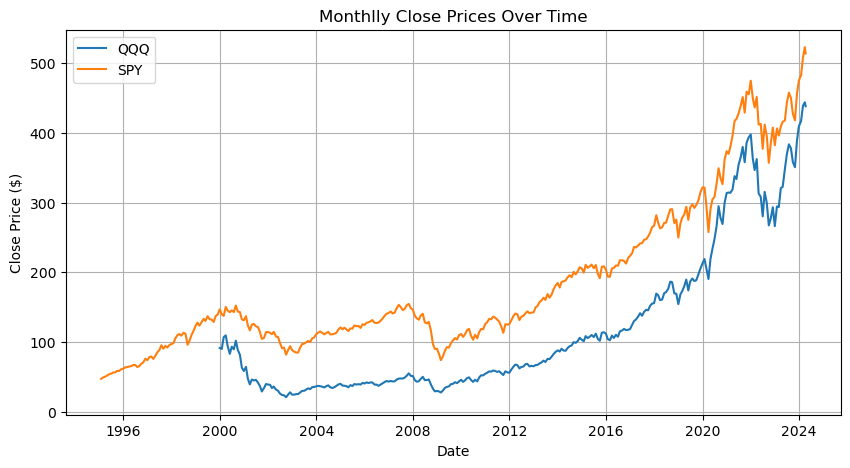

In [7]:
# Plotting the performance over time

plt.figure(figsize = (10,5))

plt.plot(qqq_monthly['time'], qqq_monthly['close'], label = 'QQQ')
plt.plot(spy_monthly['time'], spy_monthly['close'], label = 'SPY')
plt.title('Monthlly Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.legend()

plt.show()

# Model

In [8]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [9]:
LR = LinearRegression()

qqq['time_since_start'] = (qqq['time'] - qqq['time'].min()).dt.days

qqq_x_train = qqq[['time_since_start']]
qqq_y_train = qqq['close']

LR.fit(qqq_x_train, qqq_y_train)

qqq_y_pred = LR.predict(qqq_x_train)

rmse = np.sqrt(mean_squared_error(qqq_y_train, qqq_y_pred))
print(f'Root Mean Squared Error: {rmse}')

print(f'Coefficient: {LR.coef_[0]}')
print(f'Intercept: {LR.intercept_}')

Root Mean Squared Error: 59.47199485928688
Coefficient: 0.0343606055802857
Intercept: -34.4836245296016


In [ ]:
LR = LinearRegression()

qqq['time_since_start'] = (qqq['time'] - qqq['time'].min()).dt.days

qqq_x_train = qqq[['time_since_start']]
qqq_y_train = qqq['close']

LR.fit(qqq_x_train, qqq_y_train)

qqq_y_pred = LR.predict(qqq_x_train)

rmse = np.sqrt(mean_squared_error(qqq_y_train, qqq_y_pred))
print(f'Root Mean Squared Error: {rmse}')

print(f'Coefficient: {LR.coef_[0]}')
print(f'Intercept: {LR.intercept_}')